In [1]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from stock_trading import StockActor, StockCritic, TD3StockActor, TD3StockCritic, obs_normalizer, get_model_path, get_result_path, test_model, get_variable_scope, test_model_multiple
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv, max_drawdown, sharpe, sortino, create_close_dataframe, convert_prices
import tflearn
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, results_table_row, returns_from_cumulative, extract_from_infos, returns_from_cumulative

from technical_indicators.technical_indicators import full_rmr_moving_average, olmar_moving_average

tf.__version__
print("Imports Complete")







Imports Complete


In [2]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

models = []
model_names = []
framework_lst = ['TD3']
window_length_lst = [3, 7, 11, 14]
maximum_window = max(window_length_lst)
predictor_type_lst = ['lstm']
use_batch_norm = True
log_return = True
technical_indicators_flag = True
load_technical_indicators = True

In [3]:
# Stock History
dataset_name = 'SP500'
history, assets, date_list = read_stock_history(filepath='utils/datasets/{}.h5'.format(dataset_name))
history = history[:, :, :4]
nb_classes = len(history) + 1
print("Dataset: {}".format(dataset_name))
print("Assets: {}".format(assets))
print("Stock History Shape: {}".format(history.shape))
print("Full Stock History Date Range: {} -> {}".format(date_list[0], date_list[-1]))

Dataset: SP500
Assets: ['AAPL', 'MSFT', 'JNJ', 'JPM', 'PG', 'UNH', 'HD', 'DIS', 'VZ', 'CMCSA', 'ADBE', 'PFE', 'BAC', 'INTC', 'T', 'WMT', 'MRK', 'KO', 'PEP', 'ABT', 'TMO', 'CSCO', 'CVX', 'NKE', 'XOM']
Stock History Shape: (25, 6483, 4)
Full Stock History Date Range: 03/01/1995 -> 30/09/2020


In [4]:
# Training/Testing Date Range
if dataset_name == 'Hegde':
    full_length = len(date_list)
    train_ratio = 7/10
    validation_ratio = 2/10
    train_start_date = date_list[maximum_window]
    train_end_date = date_list[(int)(full_length * train_ratio) - 1]
    #validation_start_date = date_list[(int)(full_length * train_ratio)]
    #validation_end_date = date_list[(int)(full_length * (train_ratio + validation_ratio)) - 1]
    test_start_date = date_list[(int)(full_length * (train_ratio + validation_ratio))]
    test_end_date = date_list[full_length - 2]
else:
    full_length = len(date_list)
    train_test_ratio = 6/7
    train_start_date = date_list[maximum_window]
    train_end_date = date_list[(int)(full_length * train_test_ratio)-1]
    test_start_date = date_list[(int)(full_length * train_test_ratio)]
    test_end_date = date_list[full_length-2]
print("Training Date Range: {} -> {} ({} Steps)".format(train_start_date, train_end_date, 
                                                    (int)(date_list.index(train_end_date) - date_list.index(train_start_date))))
print("Testing Date Range: {} -> {} ({} Steps)".format(test_start_date, test_end_date, 
                                                    (int)(date_list.index(test_end_date) - date_list.index(test_start_date))))

Training Date Range: 23/01/1995 -> 25/01/2017 (5541 Steps)
Testing Date Range: 26/01/2017 -> 29/09/2020 (925 Steps)


In [5]:
# Generate Technical Indicators
def GenerateTechnicalIndicators(window_length, debug = False):
    if debug:
        print('history.shape: {}'.format(history.shape))

    # Check if just close is fed or full dataset
    if history.shape[2] == 4:
        # Get Close
        history_close = history[:, :, 3]
    elif history.shape[2] == 2:
        # Assume the one sent is the close price
        history_close = history[:, :, 1]

    if debug:
        print('history_close.shape: {}'.format(history_close.shape))

    # Add Technical Indicators to be included in state
    if technical_indicators_flag:
        technical_indicator_history = []

        # Close Price DataFrame for on-line Portfolio Selection
        temp_close_df = create_close_dataframe(history, assets, date_list)
        temp_close_df = convert_prices(temp_close_df, 'raw', True)    
        if debug:
            print('temp_close_df.shape: {}'.format(temp_close_df.shape))

        rmr_moving_average_df = full_rmr_moving_average(temp_close_df, window_length)
        for i in range(len(assets)):
            # Create List
            ti = []
            #ti.append([olmar_moving_average(temp_close_df[assets[i]], window_length)]) # Based on OLMAR
            ti.append([rmr_moving_average_df[assets[i]]]) # Based on RMR

            # Turn to Array
            ti = np.vstack(ti)

            ti_reshaped = []
            for j in range(temp_close_df.shape[0]):
                ti_reshaped.append(ti[:, j])   

            technical_indicator_history.append(ti_reshaped)

        technical_indicator_history = np.array(technical_indicator_history)    
        if debug:
            print('technical_indicators.shape: {}'.format(technical_indicator_history.shape)) 
    else:
        technical_indicator_history = None
        
    return technical_indicator_history

In [6]:
if technical_indicators_flag:
    if load_technical_indicators:
        # Load Technical Indicators dataset
        ti_dict = np.load('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name),allow_pickle='TRUE').item()
    else:
        ti_dict = {}
        for window_length in window_length_lst:
            technical_indicator_history = GenerateTechnicalIndicators(window_length)
            ti_dict[window_length] = technical_indicator_history
        np.save('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name), ti_dict) 

In [7]:
# instantiate environment
for framework in framework_lst:
    for window_length in window_length_lst:
        for predictor_type in predictor_type_lst:
            if technical_indicators_flag:
                name = '{}_{}_window_{}_predictor_{}_rmr-pred'.format(dataset_name, framework, window_length, predictor_type)
            else:
                name = '{}_{}_window_{}_predictor_{}'.format(dataset_name, framework, window_length, predictor_type)
            model_names.append(name)
            tf.reset_default_graph()
            sess = tf.Session()
            tflearn.config.init_training_mode()
            action_dim = [nb_classes]
            if technical_indicators_flag:
                technical_indicator_history = ti_dict[window_length]
                state_dim = [nb_classes, window_length+technical_indicator_history.shape[2]]
            else:
                state_dim = [nb_classes, window_length]

            variable_scope = get_variable_scope(dataset_name, framework, window_length, predictor_type, 
                                                use_batch_norm, technical_indicators_flag)

            with tf.variable_scope(variable_scope):

                if(framework == 'DDPG'):
                    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                       predictor_type, use_batch_norm)
                    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

                    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                                      log_return=log_return, config_file='config/stock.json', 
                                      model_save_path=model_save_path, summary_path=summary_path)
                    ddpg_model.initialize(load_weights=True, verbose=True)
                    models.append(ddpg_model)

                elif(framework == 'TD3'):
                    actor = TD3StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                          predictor_type, use_batch_norm)
                    critic = TD3StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                               inp_actions=actor.scaled_out)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

                    td3_model = TD3(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer, 
                                    log_return=log_return, config_file='config/stock.json', 
                                    model_save_path=model_save_path, summary_path=summary_path)
                    td3_model.initialize(load_weights=True, verbose=True)
                    models.append(td3_model)


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.





INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_3/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_3_batch_norm_technical_indi

INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_7/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading SP500_TD3_lstm_window_7_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: SP500_TD3_lstm_window_7_batch_norm_technical_indicato

INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_11/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading SP500_TD3_lstm_window_11_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: SP500_TD3_lstm_window_11_batch_norm_technic

INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_14/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading SP500_TD3_lstm_window_14_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: SP500_TD3_lstm_window_14_batch_norm_technic

In [8]:
model_names

['SP500_TD3_window_3_predictor_lstm_rmr-pred',
 'SP500_TD3_window_7_predictor_lstm_rmr-pred',
 'SP500_TD3_window_11_predictor_lstm_rmr-pred',
 'SP500_TD3_window_14_predictor_lstm_rmr-pred']

#### IN SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

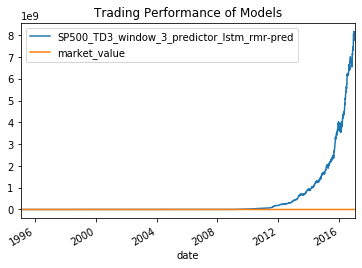

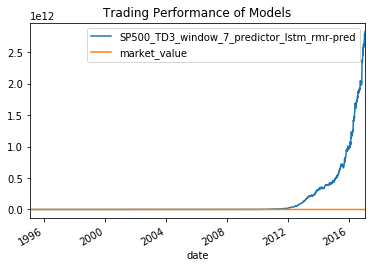

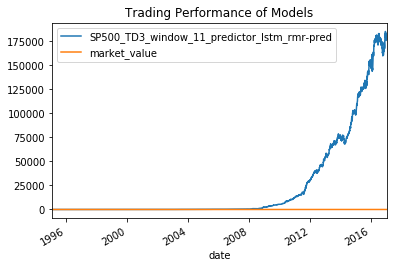

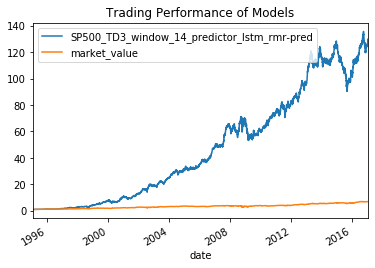

In [9]:
# Compiled Results
in_full_model_names = []
in_full_models = []
in_portfolio_values_list = [] 

for window_length in window_length_lst:
    model_names_subset = []
    models_subset = []
    for i in range(len(model_names)):
        if 'window_{}'.format(window_length) in model_names[i]:
            model_names_subset.append(model_names[i])
            models_subset.append(models[i])
            
    if technical_indicators_flag:
        env = MultiActionPortfolioEnv(history, assets, model_names_subset, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length, 
                                  technical_indicators_flag=technical_indicators_flag, 
                                  technical_indicator_history=ti_dict[window_length])
    else:
        env = MultiActionPortfolioEnv(history, assets, model_names_subset, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length)

    _, info_list, _, _ = test_model_multiple(env, models_subset)
    
    # Add to results
    for i in range(len(model_names_subset)):
        in_full_model_names.append(model_names_subset[i])
        in_full_models.append(models_subset[i])     
        in_portfolio_values_list.append(extract_from_infos(info_list, model_names_subset[i]))

In [10]:
in_dates = extract_from_infos(info_list, 'date')

##### OLPS

In [11]:
# Set Up Environment
env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=3, olps=True)

in_olps_model_names = ['CRP', 'BCRP', 'OLMAR', 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
observations_list, in_olps_portfolio_values_list, weights_list, dates = test_portfolio_selection_multiple(env, 
                                                                                                in_olps_model_names)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=========CRP=========
len(weights_array): 6483
=========BCRP=========
252.0
len(weights_array): 5542
=========OLMAR=========
len(weights_array): 5542
=========PAMR=========
len(weights_array): 5542
=========RMR=========
len(weights_array): 5542
=========WMAMR=========
len(weights_array): 5542
=========EG=========
len(weights_array): 5542
=========ONS=========
len(weights_array): 5542
=========UP=========
len(weights_array): 5542


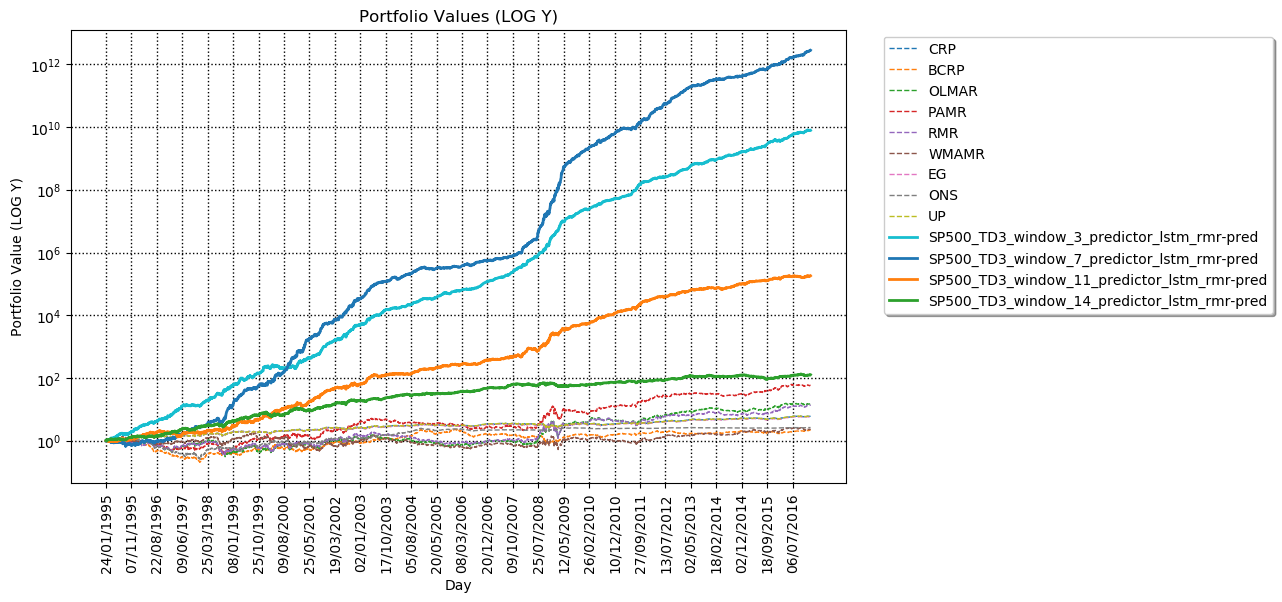

In [12]:
log_y = True

df = pd.DataFrame()
df["Date"] = in_dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

# OLPS
for i in range(len(in_olps_model_names)):
    df[in_olps_model_names[i]] = in_olps_portfolio_values_list[i]
    plt.plot(df[in_olps_model_names[i]], label=in_olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(in_full_model_names)):
    df[in_full_model_names[i]] = in_portfolio_values_list[i]
    plt.plot(df[in_full_model_names[i]], label=in_full_model_names[i], 
             linewidth=2)
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(in_dates), 200))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.30, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [13]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for i in range(len(in_full_model_names)):
    df = results_table_row(df, in_full_model_names[i],
                           returns_from_cumulative(in_portfolio_values_list[i]),
                           in_portfolio_values_list[i])

for i in range(len(in_olps_model_names)):
    df = results_table_row(df, in_olps_model_names[i],
                           returns_from_cumulative(in_olps_portfolio_values_list[i]),
                           in_olps_portfolio_values_list[i])

# Market
#df = results_table_row(df, 'market_value',
#                           returns_from_cumulative(extract_from_infos(info_list, 'market_value')),
#                           extract_from_infos(info_list, 'market_value'))
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,SP500_TD3_window_3_predictor_lstm_rmr-pred,0.4256,25.3554,42.6997,27.3258,7.912235e+09
1,SP500_TD3_window_7_predictor_lstm_rmr-pred,0.5453,23.2095,38.8886,34.8443,2.831568e+12
2,SP500_TD3_window_11_predictor_lstm_rmr-pred,0.2323,13.9289,22.4555,34.3999,1.828005e+05
3,SP500_TD3_window_14_predictor_lstm_rmr-pred,0.0949,7.7255,10.8623,29.5539,1.289360e+02
4,CRP,0.0359,4.2074,5.7869,28.2455,6.062000e+00
5,BCRP,0.0277,1.6937,2.5360,82.4258,2.242000e+00
6,OLMAR,0.0809,3.2161,4.3363,72.7012,1.553300e+01
7,PAMR,0.0985,4.3882,6.0846,68.8876,5.906800e+01
8,RMR,0.0791,3.1374,4.1962,70.7009,1.394200e+01
9,WMAMR,0.0438,1.8237,2.5436,73.1934,2.362000e+00


#### OUT OF SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

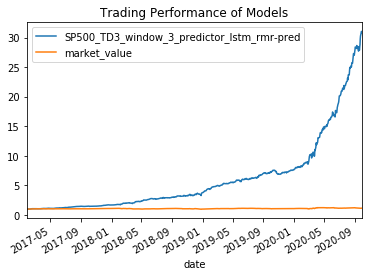

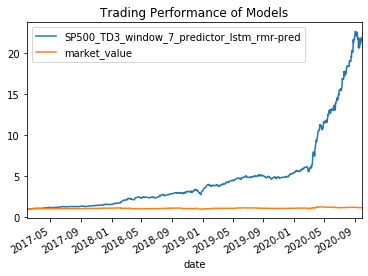

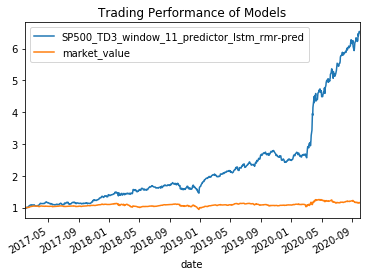

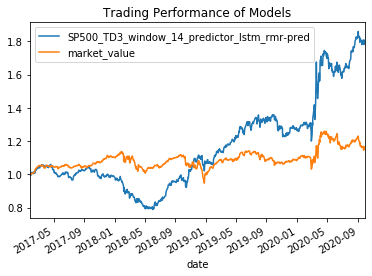

In [14]:
# Compiled Results
full_model_names = []
full_models = []
portfolio_values_list = [] 

for window_length in window_length_lst:
    model_names_subset = []
    models_subset = []
    for i in range(len(model_names)):
        if 'window_{}'.format(window_length) in model_names[i]:
            model_names_subset.append(model_names[i])
            models_subset.append(models[i])
            
    if technical_indicators_flag:
        env = MultiActionPortfolioEnv(history, assets, model_names_subset, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length, 
                                  technical_indicators_flag=technical_indicators_flag, 
                                  technical_indicator_history=ti_dict[window_length])
    else:
        env = MultiActionPortfolioEnv(history, assets, model_names_subset, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length)

    _, info_list, _, _ = test_model_multiple(env, models_subset)
    
    # Add to results
    for i in range(len(model_names_subset)):
        full_model_names.append(model_names_subset[i])
        full_models.append(models_subset[i])     
        portfolio_values_list.append(extract_from_infos(info_list, model_names_subset[i]))

#### Plot

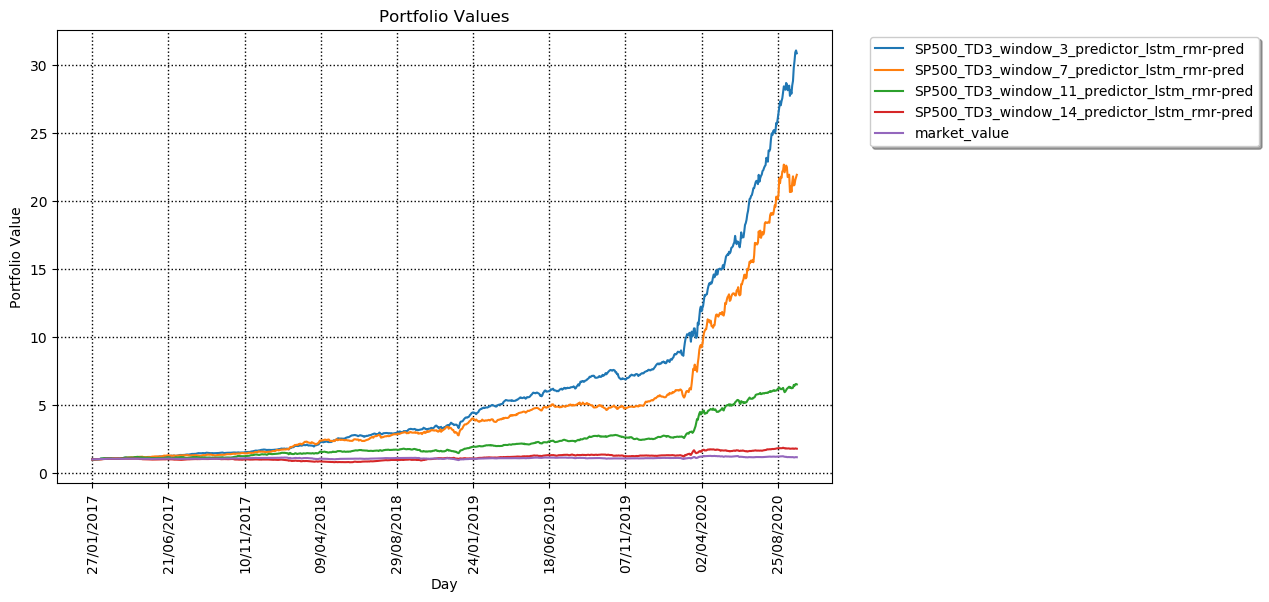

In [15]:
log_y = False
df = pd.DataFrame()
dates = extract_from_infos(info_list, 'date')
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
for i in range(len(full_model_names)):
    df[full_model_names[i]] = portfolio_values_list[i]
    plt.plot(df[full_model_names[i]], label=full_model_names[i])
df['market_value'] = extract_from_infos(info_list, 'market_value')
plt.plot(df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.30, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [16]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for i in range(len(full_model_names)):
    df = results_table_row(df, full_model_names[i],
                           returns_from_cumulative(portfolio_values_list[i]),
                           portfolio_values_list[i])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(extract_from_infos(info_list, 'market_value')),
                           extract_from_infos(info_list, 'market_value'))
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,SP500_TD3_window_3_predictor_lstm_rmr-pred,0.3789,30.3059,49.2038,10.8484,30.844
1,SP500_TD3_window_7_predictor_lstm_rmr-pred,0.3460,22.4599,35.2151,18.5811,21.913
2,SP500_TD3_window_11_predictor_lstm_rmr-pred,0.2109,16.2457,25.8760,18.5373,6.513
3,SP500_TD3_window_14_predictor_lstm_rmr-pred,0.0691,6.4011,8.7301,25.4936,1.785
4,market_value,0.0183,2.5726,3.1334,16.7101,1.160


#### Compare with online-portfolio selection

In [17]:
# Set Up Environment
env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=3, olps=True)

olps_model_names = ['CRP', 'BCRP', 'OLMAR', 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
observations_list, olps_portfolio_values_list, weights_list, dates = test_portfolio_selection_multiple(env, 
                                                                                                olps_model_names)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=========CRP=========
len(weights_array): 6483
=========BCRP=========
252.0
len(weights_array): 926
=========OLMAR=========
len(weights_array): 926
=========PAMR=========
len(weights_array): 926
=========RMR=========
len(weights_array): 926
=========WMAMR=========
len(weights_array): 926
=========EG=========
len(weights_array): 926
=========ONS=========
len(weights_array): 926
=========UP=========
len(weights_array): 926


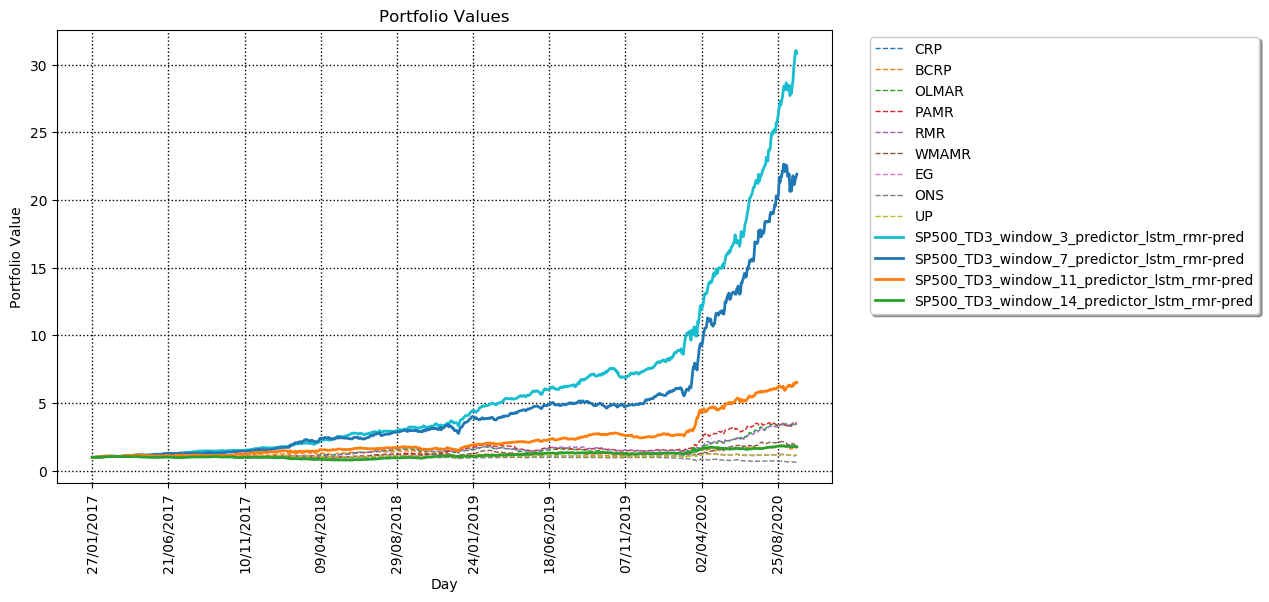

In [18]:
# Plot Together
log_y = False
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    df[full_model_names[i]] = portfolio_values_list[i]
    plt.plot(df[full_model_names[i]], label=full_model_names[i], 
             linewidth=2)
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.30, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

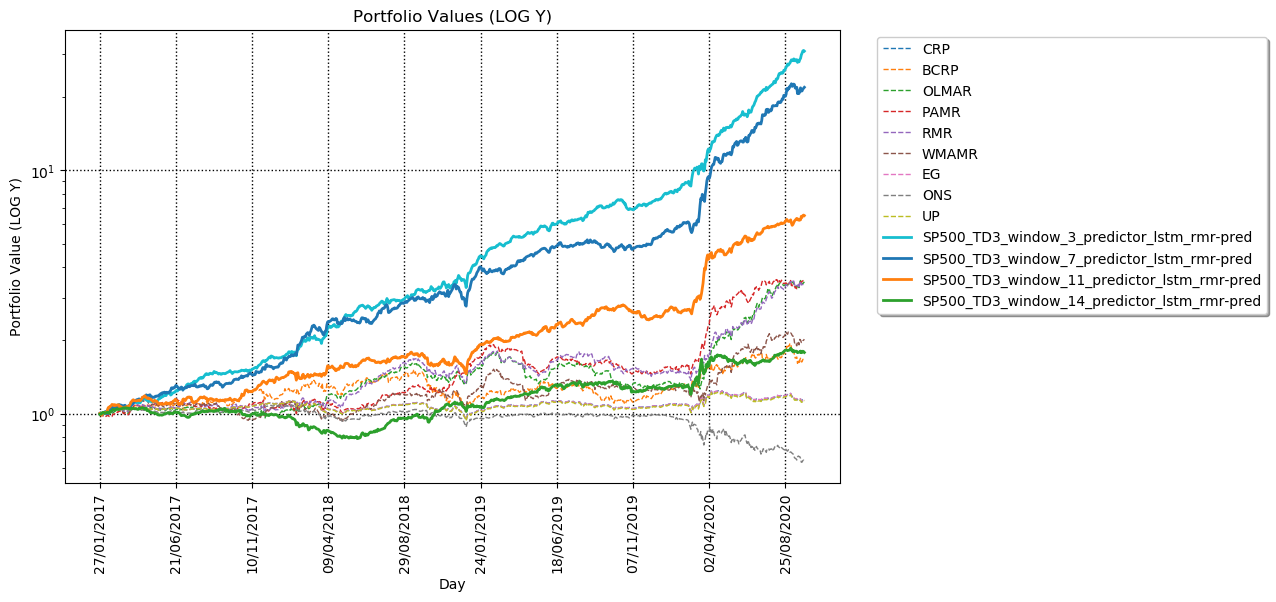

In [19]:
# Plot Together
log_y = True
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    df[full_model_names[i]] = portfolio_values_list[i]
    plt.plot(df[full_model_names[i]], label=full_model_names[i], 
             linewidth=2)
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [20]:
models = full_model_names + olps_model_names
portfolio_values = portfolio_values_list + olps_portfolio_values_list
results_table(models, portfolio_values)

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,SP500_TD3_window_3_predictor_lstm_rmr-pred,0.3789,30.3059,49.2038,10.8484,30.844
1,SP500_TD3_window_7_predictor_lstm_rmr-pred,0.3460,22.4599,35.2151,18.5811,21.913
2,SP500_TD3_window_11_predictor_lstm_rmr-pred,0.2109,16.2457,25.8760,18.5373,6.513
3,SP500_TD3_window_14_predictor_lstm_rmr-pred,0.0691,6.4011,8.7301,25.4936,1.785
4,CRP,0.0165,2.3122,2.8147,17.0722,1.140
5,BCRP,0.0704,4.2116,5.6248,33.2060,1.671
6,OLMAR,0.1453,9.7017,13.8336,32.4926,3.481
7,PAMR,0.1458,10.5078,15.1731,24.7439,3.506
8,RMR,0.1441,9.7250,14.1168,24.1961,3.451
9,WMAMR,0.0864,5.8032,8.1089,26.6575,2.023


----------------
## Rolling Analysis
1. Rolling Average Daily Yield (%) 	
2. Rolling Sharpe Ratio (%)
3. Rolling Sortino Ratio (%) 
4. Rolling Maximum Drawdown (%)

In [21]:
eps = 1e-8
def sharpe(returns, rfr=0):
    """ Given a set of returns, calculates naive (rfr=0) sharpe """
    # Clean list
    returns = [x for x in returns if str(x) != 'nan']
    if len(returns) < 10:
        return float('NaN')
    
    if isinstance(returns, list): 
        returns = np.array(returns)
    return (np.mean(returns - rfr + eps)) / np.std(returns - rfr + eps)


def sortino(returns, rfr=0):
    """ Given a set of returns, calculates naive (rfr=0) sortino """
    # Clean list
    returns = [x for x in returns if str(x) != 'nan']
    if len(returns) < 10:
        return float('NaN')
    
    if isinstance(returns, list): 
        returns = np.array(returns)
    return (np.mean(returns - rfr + eps)) / np.std([r for r in (returns - rfr + eps) if r < 0])


def max_drawdown(portfolio_value):
    """ Max drawdown. See https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp """
    # Clean list
    portfolio_value = [x for x in portfolio_value if str(x) != 'nan']
    
    mdd = 0
    peak = 0
    for i in list(range(len(portfolio_value))): 
        # Check if possible peak
        if(portfolio_value[i] > peak):
            # Max drawdown assuming this is the peak
            peak = portfolio_value[i]
            trough = min(portfolio_value[i:])
            if(peak > trough):
                d = abs((trough - peak) / peak)
                if(d > mdd):
                    mdd = d
    return mdd


In [22]:
out_dates = extract_from_infos(info_list, 'date')
selected_model = 'nyse_n_TD3_window_3_predictor_lstm_rmr-pred'
full_model_names = model_names.copy()
rolling_window = 100

##### Rolling Average Daily Yield

SP500_TD3_window_3_predictor_lstm_rmr-pred
SP500_TD3_window_7_predictor_lstm_rmr-pred
SP500_TD3_window_11_predictor_lstm_rmr-pred
SP500_TD3_window_14_predictor_lstm_rmr-pred


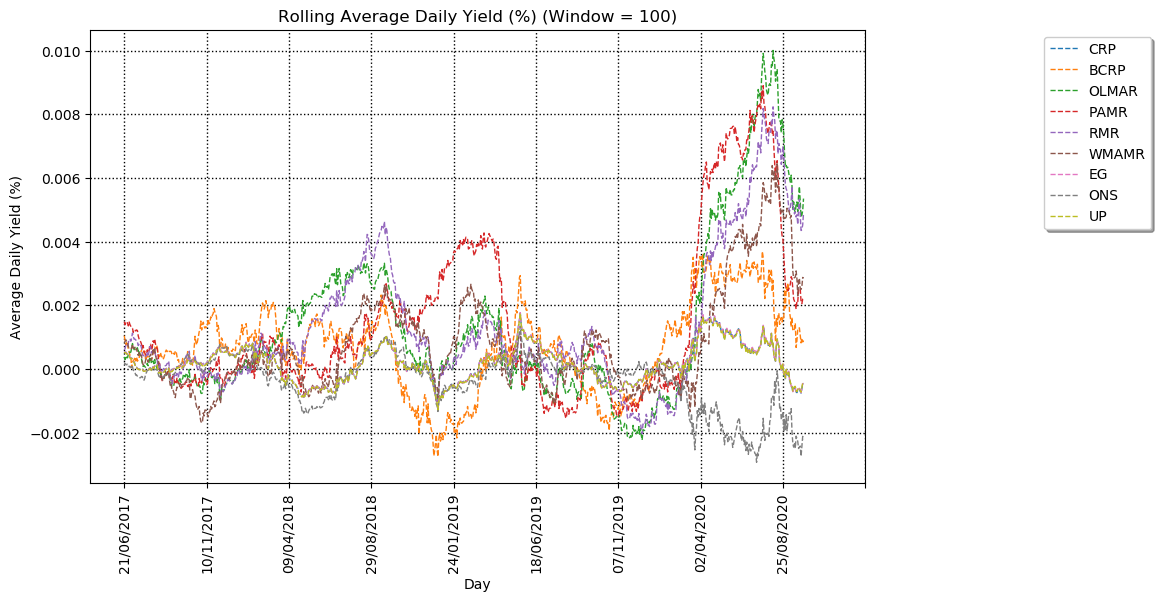

In [23]:
roll_ady_df = pd.DataFrame()
roll_ady_df["Date"] = out_dates
roll_ady_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Average Daily Yield (%) (Window = {})'.format(rolling_window))
plt.ylabel('Average Daily Yield (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_ady_df[olps_model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
    plt.plot(roll_ady_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_ady_df[full_model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
    if selected_model is not None: 
        print(full_model_names[i])
        if selected_model == full_model_names[i]:
            plt.plot(roll_ady_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)
    else:
        plt.plot(roll_ady_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(out_dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_ady_df.drop('returns', axis=1, inplace=True)

#####  Rolling Sharpe Ratio

SP500_TD3_window_3_predictor_lstm_rmr-pred
SP500_TD3_window_7_predictor_lstm_rmr-pred
SP500_TD3_window_11_predictor_lstm_rmr-pred
SP500_TD3_window_14_predictor_lstm_rmr-pred


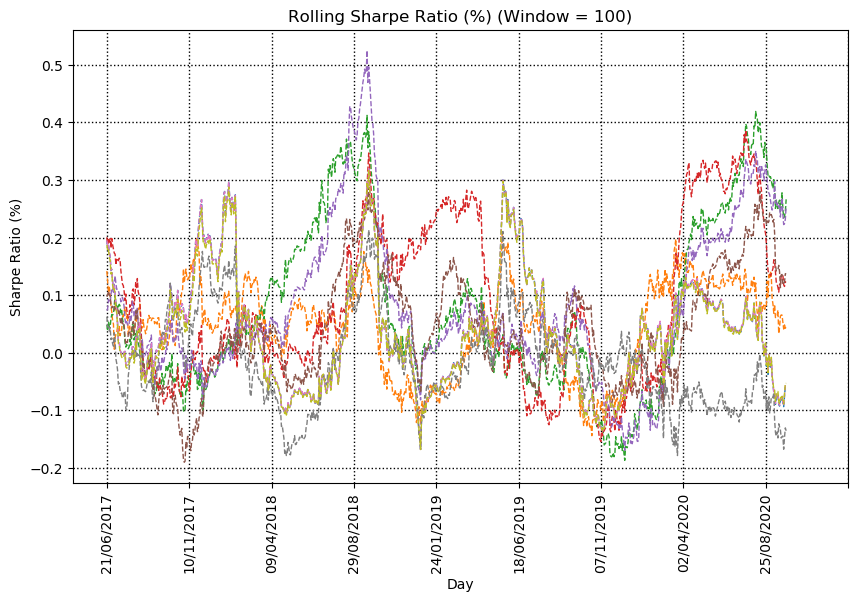

In [24]:
roll_sha_df = pd.DataFrame()
roll_sha_df["Date"] = out_dates
roll_sha_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sharpe Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sharpe Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sha_df[olps_model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
    plt.plot(roll_sha_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sha_df[full_model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
    
    if selected_model is not None: 
        print(full_model_names[i])
        if selected_model == full_model_names[i]:
            plt.plot(roll_sha_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)
    else:
        plt.plot(roll_sha_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(out_dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_sha_df.drop('returns', axis=1, inplace=True)

##### Rolling Sortino Ratio

SP500_TD3_window_3_predictor_lstm_rmr-pred
SP500_TD3_window_7_predictor_lstm_rmr-pred
SP500_TD3_window_11_predictor_lstm_rmr-pred
SP500_TD3_window_14_predictor_lstm_rmr-pred


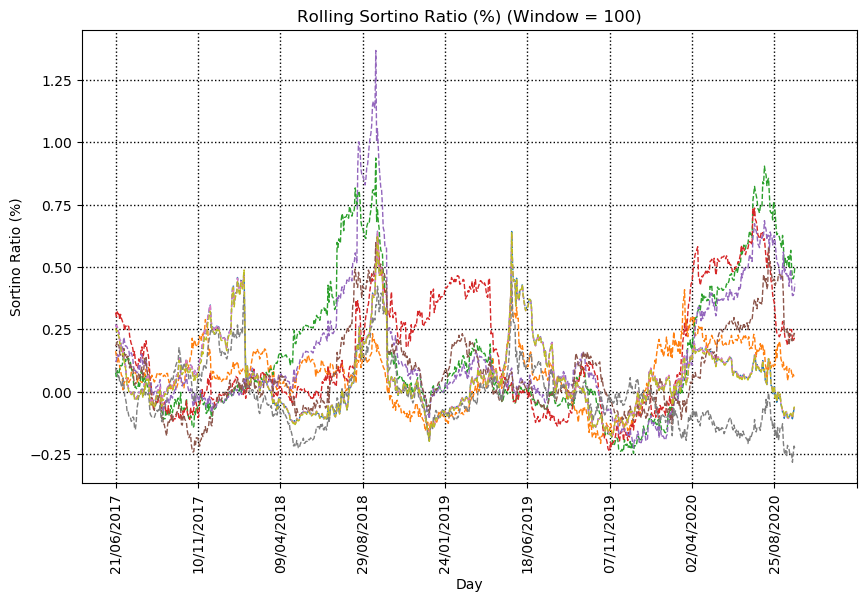

In [25]:
roll_sor_df = pd.DataFrame()
roll_sor_df["Date"] = out_dates
roll_sor_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sortino Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sortino Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sor_df[olps_model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
    plt.plot(roll_sor_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sor_df[full_model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
    
    if selected_model is not None: 
        print(full_model_names[i])
        if selected_model == full_model_names[i]:
            plt.plot(roll_sor_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)
    else:
        plt.plot(roll_sor_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(out_dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop Column
roll_sor_df.drop('returns', axis=1, inplace=True)

##### Rolling Maximum Drawdown

SP500_TD3_window_3_predictor_lstm_rmr-pred
SP500_TD3_window_7_predictor_lstm_rmr-pred
SP500_TD3_window_11_predictor_lstm_rmr-pred
SP500_TD3_window_14_predictor_lstm_rmr-pred


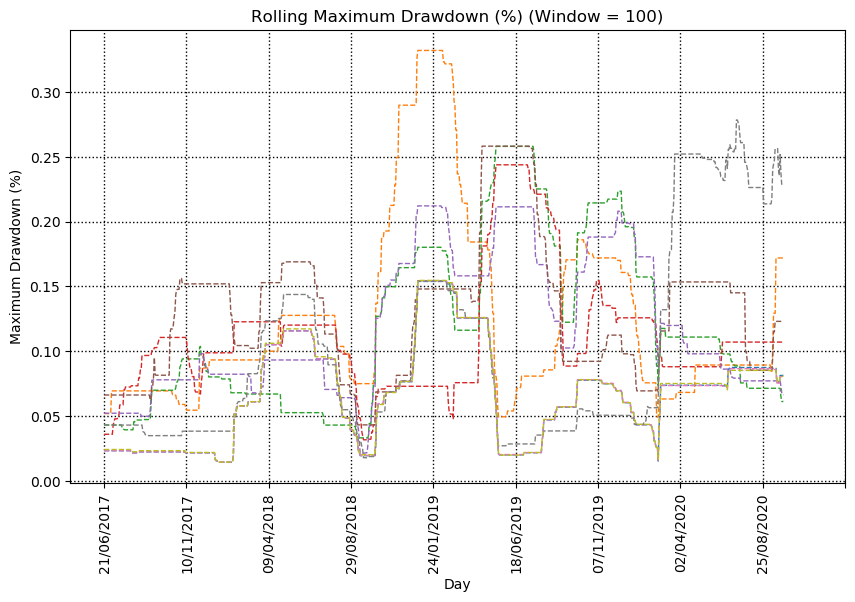

In [26]:
roll_mdd_df = pd.DataFrame()
roll_mdd_df["Date"] = out_dates
roll_mdd_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Maximum Drawdown (%) (Window = {})'.format(rolling_window))
plt.ylabel('Maximum Drawdown (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_mdd_df['portfolio'] =  olps_portfolio_values_list[i]
    roll_mdd_df[olps_model_names[i]] = roll_mdd_df['portfolio'].rolling(rolling_window).apply(max_drawdown, raw=True)
    plt.plot(roll_mdd_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    roll_mdd_df['portfolio'] =  portfolio_values_list[i]
    roll_mdd_df[full_model_names[i]] = roll_mdd_df['portfolio'].rolling(rolling_window).apply(max_drawdown, raw=True)
    
    if selected_model is not None: 
        print(full_model_names[i])
        if selected_model == full_model_names[i]:
            plt.plot(roll_mdd_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)
    else:
        plt.plot(roll_mdd_df[full_model_names[i]].iloc[rolling_window:], label=full_model_names[i], 
             linewidth=2)

plt.xticks(np.arange(0, len(out_dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop Column
roll_mdd_df.drop('portfolio', axis=1, inplace=True)

In [27]:
# Average Daily Yield (%) 	Sharpe Ratio (%) 	Sortino Ratio (%) 	Maximum Drawdown (%)
# Mean and Standard deviation
temp = roll_ady_df.mean(axis = 0, skipna = True)
ady = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
ady.insert(0, "Average Daily Yield")

temp = roll_sha_df.mean(axis = 0, skipna = True)
sha = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
sha.insert(0, "Sharpe Ratio")

temp = roll_sor_df.mean(axis = 0, skipna = True)
sor = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
sor.insert(0, "Sortino Ratio")

temp = roll_mdd_df.mean(axis = 0, skipna = True)
mdd = (1 - (temp-temp.min())/(temp.max()-temp.min())).tolist()
mdd.insert(0, "Maximum Drawdown (inverted)")

_results_df = pd.DataFrame([ady, sha, sor, mdd], columns=["Evaluation Criteria"] + roll_ady_df.columns.tolist())

_results_df.set_index('Evaluation Criteria', inplace=True)
_results_df

,CRP,BCRP,OLMAR,PAMR,RMR,WMAMR,EG,ONS,UP,SP500_TD3_window_3_predictor_lstm_rmr-pred,SP500_TD3_window_7_predictor_lstm_rmr-pred,SP500_TD3_window_11_predictor_lstm_rmr-pred,SP500_TD3_window_14_predictor_lstm_rmr-pred
Evaluation Criteria,,,,,,,,,,,,,
Average Daily Yield,0.133105,0.264505,0.426424,0.456494,0.417305,0.292593,0.133704,0.000000,0.129753,1.0,0.930023,0.603892,0.258303
Sharpe Ratio,0.161695,0.185227,0.280354,0.310145,0.293601,0.180897,0.162171,0.000000,0.152521,1.0,0.729739,0.510614,0.202981
Sortino Ratio,0.139476,0.153393,0.301766,0.302881,0.302075,0.176837,0.139390,0.000000,0.132021,1.0,0.757587,0.509174,0.177131
Maximum Drawdown (inverted),0.919113,0.054865,0.148349,0.249137,0.139967,0.000000,0.918840,0.429912,0.913216,1.0,0.655037,0.680607,0.508298


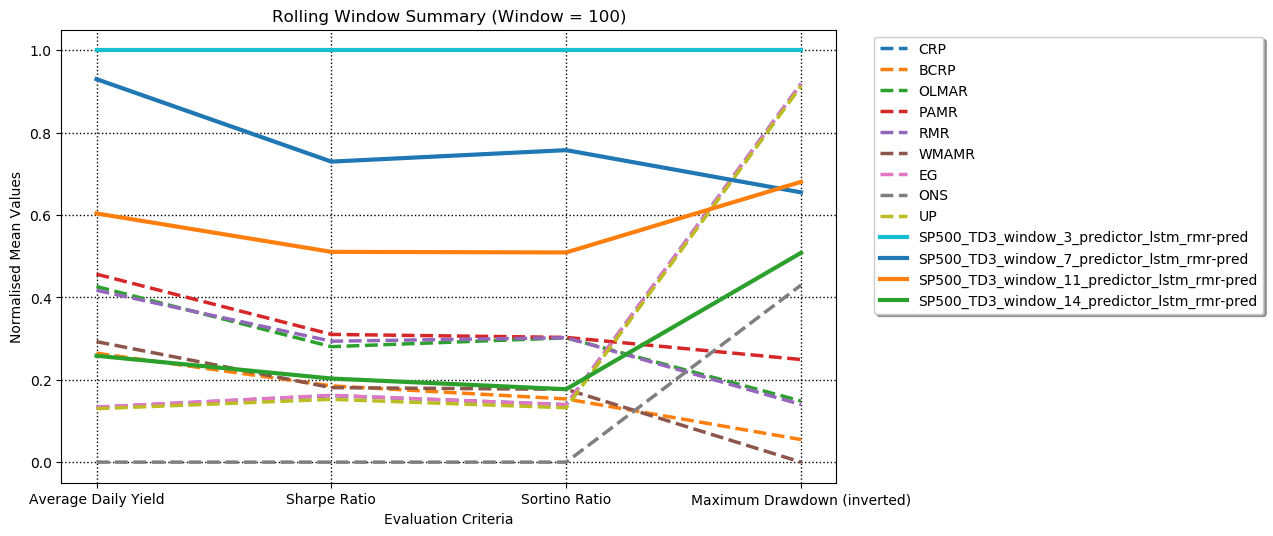

In [28]:
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Window Summary (Window = {})'.format(rolling_window))
plt.ylabel('Normalised Mean Values')
plt.xlabel('Evaluation Criteria')

# OLPS
for i in range(len(olps_model_names)):
    plt.plot(_results_df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=2.5, 
             linestyle='dashed')

# Our models
for i in range(len(full_model_names)):
    plt.plot(_results_df[full_model_names[i]], label=full_model_names[i], 
             linewidth=3)

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

### Statistical summary via T-test

In [29]:
from scipy.stats import ttest_ind_from_stats

In [30]:
# All OLPS vs TD3-14-lstm-rmr_pred
n = len(roll_ady_df)
our_model = 'nyse_n_TD3_window_3_predictor_lstm_rmr-pred'
print("{} vs... t-tests".format(our_model))

nyse_n_TD3_window_3_predictor_lstm_rmr-pred vs... t-tests


In [31]:
# Average Daily Yield (%)
mean = roll_ady_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_ady_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_ady_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

ady_tstat_list = ['ADY_tstat']
ady_pvalue_list = ['ADY_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    ady_tstat_list.append(tstat)
    ady_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

KeyError: 'nyse_n_TD3_window_3_predictor_lstm_rmr-pred'

In [ ]:
# Sharpe Ratio (%)
mean = roll_sha_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sha_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sha_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sha_tstat_list = ['SHA_tstat']
sha_pvalue_list = ['SHA_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sha_tstat_list.append(tstat)
    sha_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

In [ ]:
# Sortino Ratio (%)
mean = roll_sor_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sor_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sor_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sor_tstat_list = ['SOR_tstat']
sor_pvalue_list = ['SOR_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sor_tstat_list.append(tstat)
    sor_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

In [ ]:
# Maximum Drawdown (%)
mean = roll_mdd_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_mdd_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_mdd_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

mdd_tstat_list = ['MDD_tstat']
mdd_pvalue_list = ['MDD_pvalue']

for olps_model in olps_model_names:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    mdd_tstat_list.append(tstat)
    mdd_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat < 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

In [ ]:
stat_df = pd.DataFrame([ady_tstat_list, ady_pvalue_list, 
                       sha_tstat_list, sha_pvalue_list, 
                       sor_tstat_list, sor_pvalue_list, 
                       mdd_tstat_list, mdd_pvalue_list], columns=['value']+olps_model_names)
stat_df.set_index('value', inplace=True)
stat_df

In [ ]:
stat_df.T